# Library and dataset setup

In [1]:
!pip install pyspark

In [5]:
import pandas as pd
import requests
import numpy as np


### Load the required packages in the required format

%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")

import pyspark




In [6]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"luigirachiele","key":"47ab4d1b758be41dba8aff5c82f8f8b4"}'}

In [7]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
#!kaggle datasets list
!kaggle datasets download -d ashwinik/spotify-playlist
!unzip spotify-playlist.zip

 98% 180M/183M [00:02<00:00, 80.4MB/s]
100% 183M/183M [00:02<00:00, 84.4MB/s]
Archive:  spotify-playlist.zip
  inflating: README.txt              
  inflating: spotify_dataset.csv     


In [28]:
spotify_data = pd.read_csv('/content/spotify_dataset.csv',escapechar= '.',error_bad_lines = False,warn_bad_lines=False)
spotify_data.columns = ['user_id','artistname','trackname','playlistname']
print ("Read Succesful with shape {}".format(spotify_data.shape))

Read Succesful with shape (12774191, 4)


In [9]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.config("spark.driver.memory","12g").appName('Practise').getOrCreate()

# Spotify API

In [11]:
import sys
import spotipy
import spotipy.util as util

idPlaylist = '4XoMUd3cPgLeazj8ezngUu';
username = 'gixs'


def show_tracks(tracks):
    for i, item in enumerate(tracks['items']):
        track = item['track']
        print("   %d %32.32s %s" % (i, track['artists'][0]['name'],
            track['name']))


def getSinglePlaylist (playlistId, sp, username):
    return sp.user_playlist (user = username, playlistId = playlistId, fields="tracks, next")




def createClient():
    if len(sys.argv) > 1:
        username = sys.argv[1]
    else:
        print("Whoops, need your username!")
        print("usage: python user_playlists.py [username]")
        sys.exit()

        token = util.prompt_for_user_token(username)

        if token:
            sp = spotipy.Spotify(auth=token)
            return sp

        else:
            print("Can't get token for", username)
            return null


token = util.prompt_for_user_token(username)

if token:
  sp = spotipy.Spotify(auth=token)

else:
  print("Can't get token for", username)

singlePlaylist = sp.user_playlist (user = username, playlist_id = idPlaylist, fields="tracks, next")
tracks = singlePlaylist ['tracks']

ModuleNotFoundError: ignored

# Dataset analysis

In [12]:
print ("Some General statistics about data are as follows:",spotify_data.info())
print ("Lets look at the summary stats about the data :",spotify_data.describe(include ='object'))
print ("The number of rows in the datasets are as follows :",spotify_data.shape[0])
print (" The columns in the data are as follows :",spotify_data.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12774191 entries, 0 to 12774190
Data columns (total 4 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   user_id       object
 1   artistname    object
 2   trackname     object
 3   playlistname  object
dtypes: object(4)
memory usage: 389.8+ MB
Some General statistics about data are as follows: None
Lets look at the summary stats about the data :                                  user_id artistname trackname playlistname
count                           12774191   12741100  12774090     12634598
unique                             15897     303027   2057995       155522
top     4398de6902abde3351347b048fcdc287  Daft Punk   Starred      Starred
freq                              295274      35805     11159      1320739
The number of rows in the datasets are as follows : 12774191
 The columns in the data are as follows : Index(['user_id', 'artistname', 'trackname', 'playlistname'], dtype='object')


First of all, see some analysis on the data.

### Here there is the distribution of number of playlist by *user id*.

In [13]:
spotify_user_summary = spotify_data.groupby(['user_id'])["playlistname"].nunique().reset_index()

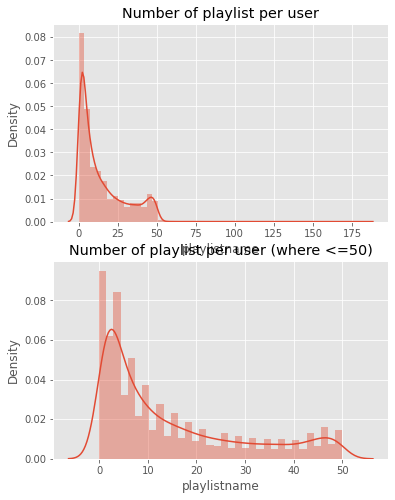

In [14]:
#GRAPH
### Just for better visualisation remove very high playlist
%matplotlib inline
fig, ax = plt.subplots(2, figsize=(6,8))
sns.distplot(spotify_user_summary['playlistname'], hist=True,ax = ax[0])
ax[0].set_title("Number of playlist per user")
spotify_user_summary = spotify_user_summary[spotify_user_summary['playlistname'] <= 50]
sns.distplot(spotify_user_summary['playlistname'], hist=True,ax=ax[1])
ax[1].set_title("Number of playlist per user (where <=50)")
plt.show()

###Then visualize the distribution of number of *artist* for each *user_id*.

In [15]:
spotify_user_summary = spotify_data.groupby(['user_id'])["artistname"].nunique().reset_index()

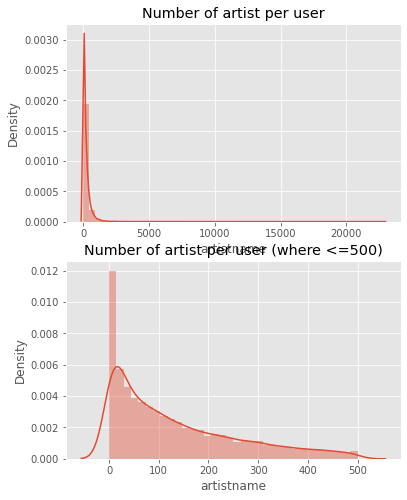

In [16]:
#GRAPH

%matplotlib inline
### Just for better visualisation remove very high playlist
fig, ax = plt.subplots(2, figsize=(6,8))
sns.distplot(spotify_user_summary["artistname"], hist=True,ax = ax[0])
ax[0].set_title("Number of artist per user")
spotify_user_summary = spotify_user_summary[spotify_user_summary["artistname"] <= 500]
sns.distplot(spotify_user_summary["artistname"], hist=True,ax=ax[1])
ax[1].set_title("Number of artist per user (where <=500)")
plt.show()

### Then check the most common playlist names.
I removed the first 3 playlist that was given by spotify:


*   Starred
*   Liked from Radio
*   Favorites de la radio



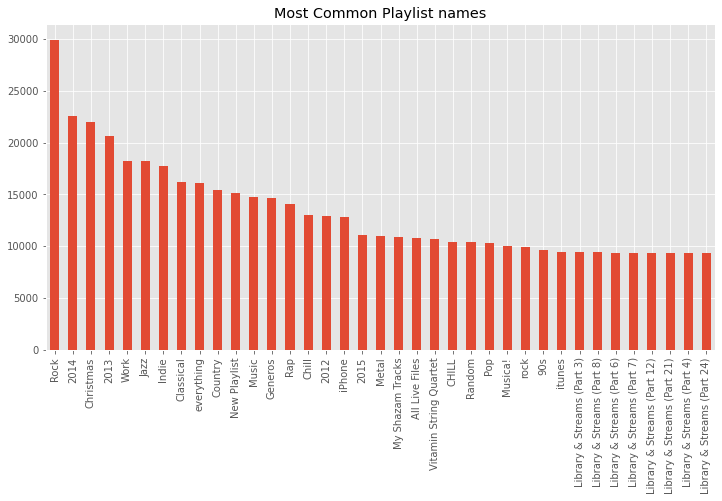

In [33]:
%matplotlib inline
### Lets have a look at most common playlist
## We could have aslo created a word cloud
spotify_data['playlistname'].value_counts()[3:40].plot(kind= 'bar',title="Most Common Playlist names",figsize = (12,6))

### Here visualize the top 50 Most Popular Artisti

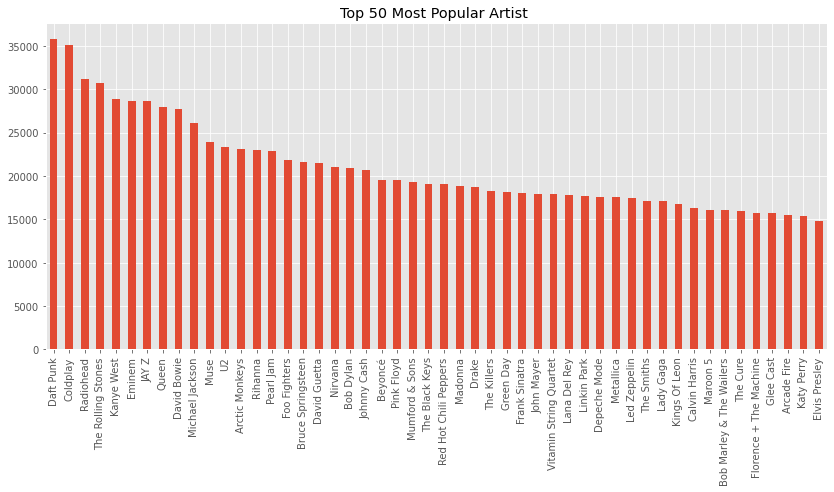

In [40]:
%matplotlib inline
spotify_data['artistname'].value_counts()[0:50].plot(kind= 'bar',title="Top 50 Most Popular Artist ",figsize = (14,6))

### Here visualize the top 50 Most Popular Songs, removing the song that have common name like:


*   Starred
*   Intro
*   Home
*   Closer



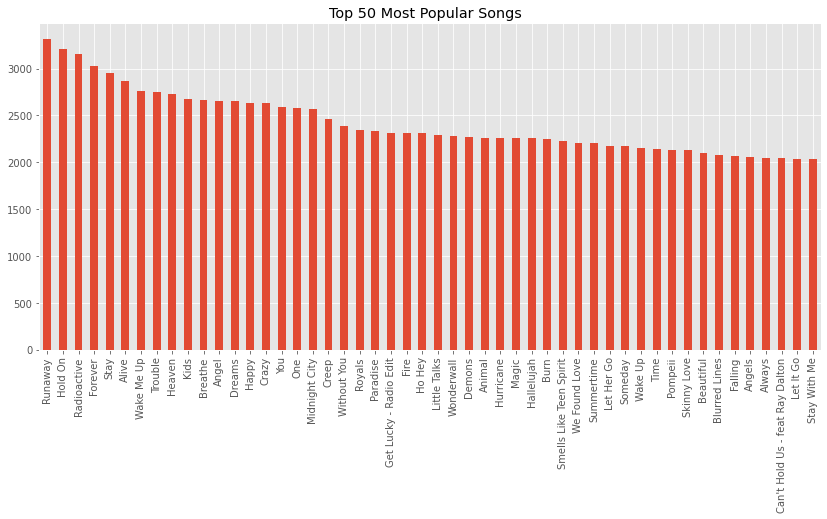

In [39]:
%matplotlib inline
### Lets have a look at most common playlist
## We could have aslo created a word cloud
spotify_data['trackname'].value_counts()[4:54].plot(kind= 'bar',title="Top 50 Most Popular Songs  ",figsize = (14,6))

# Data Preprocessing 
In this section there is the preprocessing of data.

First of all, let's drop some useless rows:


*   The rows containing null value
*   The rows that contain the songs with "intro, home, starred, closer", that's beacause it will affect negatively the algorith of FP-growth.



In [20]:
tracklist = spotify_data['trackname'].unique()

In [21]:
spotify_data.dropna(inplace = True)
spotify_data = spotify_data[~spotify_data['trackname'].str.startswith("intro", na=False)]
spotify_data = spotify_data[~spotify_data['trackname'].str.startswith("Home", na=False)]
spotify_data = spotify_data[~spotify_data['trackname'].str.contains("Starred", na=False)]
spotify_data = spotify_data[~spotify_data['trackname'].str.startswith("Closer", na=False)]

## Now lets define function which creates a dictionary and convert songs names to dictionary. 
That's helpful to reduce the computation cost. Obviously *Integer* are lighter respcet to *String*.

In [22]:
def create_dict(dataset, column):
    ''' Takes two input from user column name and dataset name and return dictionary with hash map '''
    unique_list = dataset[column].unique()
    out_dict = {}
    out_dict1 = {}
    
    for j,i in enumerate(unique_list):
        out_dict[i.lower()] = str(j)
        out_dict1[str(j)] = i.lower()
        
    print ("Number of distinct in vocab is :",j)
    return (out_dict,out_dict1)

In [23]:
track_map, track_map_comp= create_dict(spotify_data,'trackname')
artist_map,artist_map_comp = create_dict(spotify_data,'artistname')

Number of distinct in vocab is : 1976546
Number of distinct in vocab is : 285437


### Save the dictionary as pickle file, so it will be not needed to create dict every time, but we can upload as pickle.

In [24]:
with open('track_map_dict.pickle','wb') as track_file:
    pickle.dump(track_map,track_file)
with open('track_map_comp_dict.pickle','wb') as track_file_comp:
    pickle.dump(track_map_comp,track_file_comp)

In [25]:
with open('artist_map_dict.pickle','wb') as artist_file:
    pickle.dump(artist_map,artist_file)
with open('artist_map_comp_dict.pickle','wb') as artist_file_comp:
    pickle.dump(artist_map_comp,artist_file_comp)

In [10]:
### Load methods
with open('track_map_dict.pickle','rb') as dict1:
    track_dict= pickle.load( dict1)
print ("Track dict has {} observations".format(len(track_dict)))
#### Load the prcikle file for artist to numeric
with open('artist_map_dict.pickle','rb') as dict2:
    artist_dict = pickle.load(dict2)
print ("Artist dict has {} observations".format(len(artist_dict)))

Track dict has 1864427 observations
Artist dict has 277987 observations


In [27]:
### Now we will use this mapping to convert names to numeric
print ("Data before mapping dict :", spotify_data.head(5))
spotify_data['trackname'] = spotify_data['trackname'].str.lower().map(track_dict)
spotify_data['artistname'] = spotify_data['artistname'].str.lower().map(artist_dict)
print ("Data after mapping dict :")
print (spotify_data.head(5))

Data before mapping dict :                             user_id  ...    playlistname
0  9cc0cfd4d7d7885102480dd99e7a90d6  ...  HARD ROCK 2010
1  9cc0cfd4d7d7885102480dd99e7a90d6  ...  HARD ROCK 2010
2  9cc0cfd4d7d7885102480dd99e7a90d6  ...  HARD ROCK 2010
3  9cc0cfd4d7d7885102480dd99e7a90d6  ...  HARD ROCK 2010
4  9cc0cfd4d7d7885102480dd99e7a90d6  ...  HARD ROCK 2010

[5 rows x 4 columns]
Data after mapping dict :
                            user_id artistname trackname    playlistname
0  9cc0cfd4d7d7885102480dd99e7a90d6          0   1514247  HARD ROCK 2010
1  9cc0cfd4d7d7885102480dd99e7a90d6      49541    544038  HARD ROCK 2010
2  9cc0cfd4d7d7885102480dd99e7a90d6          2         2  HARD ROCK 2010
3  9cc0cfd4d7d7885102480dd99e7a90d6      49541   1516450  HARD ROCK 2010
4  9cc0cfd4d7d7885102480dd99e7a90d6          0         4  HARD ROCK 2010


### In order to get the file in the format **[playlistname, array_of_track]** it is necessary to create a zip_list method to aplly on the dataset.

In [28]:
### We want to create a list of songs in zip file 
def zip_list(x):
    return ([int(z) for z in x])

In [29]:
spotify_summary = spotify_data.groupby(['user_id','playlistname'])['trackname'].apply(zip_list).reset_index()

In [30]:
print (" Distinct playlist after summarizing the data is :",spotify_summary.shape[0])
print (" The data looks like this :")
print (spotify_summary.head(5))

 Distinct playlist after summarizing the data is : 229155
 The data looks like this :
                            user_id  ...                                          trackname
0  00055176fea33f6e027cd3302289378b  ...  [9608, 2586, 46634, 9609, 1137195, 37306, 6327...
1  0007f3dd09c91198371454c608d47f22  ...                [174795, 1537, 877677, 17529, 5292]
2  0007f3dd09c91198371454c608d47f22  ...  [1852573, 174795, 1682684, 954395, 19579, 1478...
3  0007f3dd09c91198371454c608d47f22  ...                                 [1509309, 1446920]
4  000b0f32b5739f052b9d40fcc5c41079  ...                                  [1280348, 487024]

[5 rows x 3 columns]


In [31]:
### We will Dump this data in the pickle file and work in it later
with open("spotify_summary.pickle",'wb') as pick_data:
    pickle.dump(spotify_summary,pick_data)

### I created also the playlist dictionary, but I didn't utilize for this script.

In [32]:
playlist_map, playlist_map_comp= create_dict(spotify_data,'playlistname')

Number of distinct in vocab is : 155321


In [33]:
with open('playlist_map_dict.pickle','wb') as playlist_file:
    pickle.dump(playlist_map,playlist_file)
with open('playlist_map_comp_dict.pickle','wb') as playlist_file_comp:
    pickle.dump(playlist_map_comp,playlist_file_comp)

In [34]:
print ("Data before mapping dict :", spotify_data.head(5))
spotify_summary['playlistname'] = spotify_summary['playlistname'].str.lower().map(playlist_map)
print ("Data after mapping dict :")
print (spotify_summary.head(5))

Data before mapping dict :                             user_id artistname trackname    playlistname
0  9cc0cfd4d7d7885102480dd99e7a90d6          0   1514247  HARD ROCK 2010
1  9cc0cfd4d7d7885102480dd99e7a90d6      49541    544038  HARD ROCK 2010
2  9cc0cfd4d7d7885102480dd99e7a90d6          2         2  HARD ROCK 2010
3  9cc0cfd4d7d7885102480dd99e7a90d6      49541   1516450  HARD ROCK 2010
4  9cc0cfd4d7d7885102480dd99e7a90d6          0         4  HARD ROCK 2010
Data after mapping dict :
                            user_id  ...                                          trackname
0  00055176fea33f6e027cd3302289378b  ...  [9608, 2586, 46634, 9609, 1137195, 37306, 6327...
1  0007f3dd09c91198371454c608d47f22  ...                [174795, 1537, 877677, 17529, 5292]
2  0007f3dd09c91198371454c608d47f22  ...  [1852573, 174795, 1682684, 954395, 19579, 1478...
3  0007f3dd09c91198371454c608d47f22  ...                                 [1509309, 1446920]
4  000b0f32b5739f052b9d40fcc5c41079  ...         

# FP Growth

## Now setup the playlist in which the predict needs to be done.

In [8]:
playlist_string = ["Till I Collapse", "Lose Yourself", "Love is a Laserquest", "Madness", "Man in Black", "Notion", "The Song You Sing", "Complicated", "Get lucky"]

In [7]:
def playlist_to_int (playlist_string, dict):
  result = []
  for x in playlist_string:
    if (x.lower() in dict):
      result.append(int(dict.get(x.lower())))
  
  return result


In [11]:
playlist_int = playlist_to_int(playlist_string, track_dict)

Select the needed column on dataset

In [39]:
spotify_summary_pandas_selected = spotify_summary[['playlistname', 'trackname']]

In [40]:
spotify_summary_pandas_selected

,playlistname,trackname
0,45800,"[9608, 2586, 46634, 9609, 1137195, 37306, 6327..."
1,850,"[174795, 1537, 877677, 17529, 5292]"
2,95327,"[1852573, 174795, 1682684, 954395, 19579, 1478..."
3,134508,"[1509309, 1446920]"
4,28210,"[1280348, 487024]"
...,...,...
229150,121343,"[181459, 2313, 63638, 2890, 2954, 1682677, 167..."
229151,121344,"[233650, 1457, 62517, 106134, 1415671, 502479,..."
229152,121345,"[196633, 1531, 197104, 24277, 114148, 37306, 6..."
229153,121346,"[31617, 1516653, 141317, 37189, 1954879, 26123..."


In [41]:
### We will Dump this data in the pickle file to work in it later
with open("spotify_summary_pandas_selected.pickle",'wb') as pick_data:
    pickle.dump(spotify_summary_pandas_selected,pick_data)

## From here can start the spark code

In [1]:
import pandas as pd
import requests
import numpy as np


### Load the required packages in the required format

%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")

import pyspark


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Practise").config("spark.executor.memory", "5g").config("spark.driver.memory", "5g").getOrCreate()

In [3]:
with open("spotify_summary_pandas_selected.pickle",'rb') as pick_data:
    spotify_summary_pandas_selected = pickle.load(pick_data)

In [4]:
spotify_dataframe_from_pickle = spark.createDataFrame(spotify_summary_pandas_selected)

Process the FP Growth in the whole dataset is not possible for this machine. So we need to create a subset from our big main dataset: 

---
The roole chosen for the subset is:
if a song that are in the playlist in which I need to perform the prediction appears in one playlist in the dataset add this playlist to the dataset.


In [5]:
from pyspark.sql.functions import array_contains


def create_dataframe(dataset, playlist):
  notAssegnato = True
  filtred_array = []
  for i in range (len(playlist)):
    filtred_array.append(dataset.filter(array_contains(dataset.trackname, playlist[i])))
    if notAssegnato:
      result = filtred_array[0]
      notAssegnato = False
    else:
      result = result.union(filtred_array[i])
  return result

In [12]:
filtred_dataset = create_dataframe(spotify_dataframe_from_pickle, playlist_int)

Now eliminate the row with duplicate because each item in transaction must be unique. 

In [13]:
from pyspark.sql.functions import array_distinct
filtred_dataset = filtred_dataset.withColumn("arraycol_without_dupes", array_distinct("trackname"))

In [14]:
filtred_dataset = filtred_dataset.select('playlistname','arraycol_without_dupes')
filtred_dataset.cache()

DataFrame[playlistname: string, arraycol_without_dupes: array<bigint>]

## There is the code for the FPGrowth algorithm.
I started with an high *minSupport* but in many transaction is not a good idea -> no association rules will not be found.

Then i proceed with a low minSupport, but this machine crashes after some cycles, beacuse the Tree was too big.

My last attempt was at 0.05, that's a good minSupport, with minConfidence of 0.6.
I found severeal association rules, below rappresented.

In [15]:
from pyspark.ml.fpm import FPGrowth

fpGrowth = FPGrowth(itemsCol="arraycol_without_dupes", minSupport = 0.05, minConfidence = 0.6 )
model = fpGrowth.fit(filtred_dataset)

# Display frequent itemsets.
model.freqItemsets.show()

# Display generated association rules.
model.associationRules.show()

# transform examines the input items against all the association rules and summarize the
# consequents as prediction
model.transform(filtred_dataset).show()

+---------+----+
|    items|freq|
+---------+----+
|   [3339]| 249|
|[1144260]| 242|
|[1731989]| 253|
|[1951486]| 245|
|  [22670]| 235|
|[1663144]| 258|
|[1731998]| 261|
|[1528087]| 239|
|  [20720]| 265|
|  [11688]| 283|
|[1299148]| 346|
| [783311]| 270|
| [477019]| 322|
|[1619510]| 289|
| [602685]| 277|
|[1283206]| 335|
| [264868]| 296|
| [703061]| 303|
|  [11490]| 311|
|    [953]| 430|
+---------+----+
only showing top 20 rows

+--------------------+----------+------------------+------------------+--------------------+
|          antecedent|consequent|        confidence|              lift|             support|
+--------------------+----------+------------------+------------------+--------------------+
|[1273233, 1198588...| [1273225]|0.9919224555735057| 5.617703171191326| 0.13077742279020235|
|[1273233, 1198588...| [1307189]|0.9983844911147012| 5.830118390278012|   0.131629392971246|
|[1273233, 1198588...| [1307182]|0.9935379644588045| 6.329254739666332| 0.13099041533546327|
|[127323

I created the playlist dataset (with the playlist taken by spotipy) and applied the model.

In [16]:
playlist_dataset = spark.createDataFrame(
    [
        ("mine", playlist_int),  # create your data here, be consistent in the types.
    ],
    ["playlistname", "arraycol_without_dupes"]  # add your column names here
)

In [26]:
model.transform(playlist_dataset).show(5, False)
prediction_list = model.transform(playlist_dataset).collect()
prediction_list_isolated = prediction_list[0][2]

+------------+-----------------------------------------------------------------------+----------------------------------------------------+
|playlistname|arraycol_without_dupes                                                 |prediction                                          |
+------------+-----------------------------------------------------------------------+----------------------------------------------------+
|mine        |[36279, 179946, 77361, 1249398, 1641151, 6663, 204989, 841582, 1273228]|[3699, 7177, 11218, 407814, 783254, 918033, 1860817]|
+------------+-----------------------------------------------------------------------+----------------------------------------------------+



In [19]:
### Import the complementary dictonary to convert int to string

with open('track_map_comp_dict.pickle','rb') as dict1:
    track_dict_comp= pickle.load( dict1)

In [20]:
def convert_prediction (prediction_list, dict):
  result = []
  for i in range(len(prediction_list)):
    result.append (dict.get(str(prediction_list[i])))

  return result

In [21]:
prediction_list_string = convert_prediction(prediction_list_isolated, track_dict_comp)

In [22]:
print (prediction_list_string)

['crawl', 'revelry', 'manhattan', 'use somebody', 'sex on fire', 'i want you', 'be somebody']
